In [ ]:
!pip install fastai

In [ ]:
!curl -L "https://public.roboflow.com/ds/DfLfITi5kV?key=qmBN0aAJmm" > robflow.zip ; unzip robflow.zip; rm robflow.zip

In [3]:
from fastai.vision import *
import numpy as np
from fastai.metrics import error_rate
from fastai.callbacks import EarlyStoppingCallback, SaveModelCallback

In [ ]:
np.random.seed(42)

path = Path('/content/')
data = ImageDataBunch.from_folder(path, size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes

In [ ]:
data.show_batch(rows=3, figsize=(7, 8))

In [ ]:
# Import model from torchvision. For more details => https://pytorch.org/vision/0.8/models.html
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [8]:
# Callbacks
# Stop training if loss increse or not change
early_stop_callback = EarlyStoppingCallback(learn, patience=10)
best_model = SaveModelCallback(learn, name="Best_model")

In [ ]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(1,callbacks=[early_stop_callback, best_model])

In [ ]:
#Load best train model
learn.load("Best_model")

In [11]:
#Unfreeze model
#More details https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/2
learn.unfreeze()

In [12]:
def find_learing_rate(model: Learner, lr_diff:int=15, loss_threshold: float = 0.5, adjust_value : float=1, plot:bool =False)->float:
  #Run learning rate(lr) finder
  model.lr_find()

  #get loss values and their corresfonding gradients, and get lr values
  losses = np.array(model.recorder.losses)
  min_loss_index = np.argmin(losses)

  # loss_grad = np.gradient(losses)
  lrs = model.recorder.lrs

  #return the lr that produce the minimum loss divide by 10
  return lrs[min_loss_index]


In [ ]:
lr = find_learing_rate(learn)

In [ ]:
learn.fit_one_cycle(50, max_lr=slice(lr/10, lr), callbacks=[early_stop_callback, best_model])

In [ ]:
learn.load("Best_model")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(9, figsize=(15, 15))

In [ ]:
import glob
from IPython.display import Image, display
model = learn.model
model = model.cuda()
for image_name in glob.glob('/content/test/*/*.jpg'):
  print(image_name)
  img = open_image(image_name)
  pred = learn.predict(img)
  print(pred[0])
  display(Image(filename=image_name))
  print('\n')


In [30]:
# !cp -r '/content/models/Best_model.pth' '/content/drive/MyDrive/Research/ResNet34_model/'
# !cp -r '/content/models/tmp.pth' '/content/drive/MyDrive/Research/ResNet34_model/'

# ***Grad Cam Impl***

In [8]:
# !mkdir models
# !cp -r '/content/drive/MyDrive/Research/ResNet34_model/Best_model.pth' '/content/models/'
# !cp -r '/content/drive/MyDrive/Research/ResNet34_model/tmp.pth' '/content/models/'

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from math import ceil

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn.load("Best_model")

In [13]:
#Batch size. In default it 64
bs = 64 

In [ ]:
#indexing into learn.model to get the building blocks of the model.
learn.model[0][0]

In [ ]:
learn.model[0][4][0]

In [ ]:
# path = untar_data(URLs.PETS)/'/valid'

In [16]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=.2, p_lighting=.2)
# src = ImageItemList.from_folder('/content/').random_split_by_pct(0.2, seed=2)
src = data

In [17]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

class name: dandelion
class_index: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


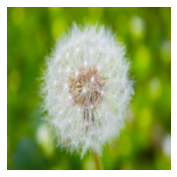

In [18]:
idx=4
x,y = data.valid_ds[idx]
x.show()
print(f'class name: {y}\nclass_index: {y.data}')

In [19]:
m = learn.model.eval();

In [20]:
xb,_ = data.one_item(x)    #get tensor from Image x
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [21]:
def non_class_discriminative_activations_multi(xb):
    hooks = []
    layer_names = []
    
    hooks.append(hook_output(m[0][3]))
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learn.model[0][ind]):
            hooks.append(hook_output(el))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            # layer 1 (layer is combination of resnet blocks) is model[0][4]
    
    preds = m(xb)
    
    for hook in hooks:
        hook.remove()
    
    return hooks,layer_names

In [22]:
hooks,layer_names = non_class_discriminative_activations_multi(xb)

In [23]:
for layer_name,hook in zip(layer_names,hooks):
    print(f'{layer_name}{" "*(18-len(layer_name))} -->   {hook.stored[0].shape}')

first conv         -->   torch.Size([64, 56, 56])
layer-1 - conv-1   -->   torch.Size([64, 56, 56])
layer-1 - conv-2   -->   torch.Size([64, 56, 56])
layer-1 - conv-3   -->   torch.Size([64, 56, 56])
layer-2 - conv-1   -->   torch.Size([128, 28, 28])
layer-2 - conv-2   -->   torch.Size([128, 28, 28])
layer-2 - conv-3   -->   torch.Size([128, 28, 28])
layer-2 - conv-4   -->   torch.Size([128, 28, 28])
layer-3 - conv-1   -->   torch.Size([256, 14, 14])
layer-3 - conv-2   -->   torch.Size([256, 14, 14])
layer-3 - conv-3   -->   torch.Size([256, 14, 14])
layer-3 - conv-4   -->   torch.Size([256, 14, 14])
layer-3 - conv-5   -->   torch.Size([256, 14, 14])
layer-3 - conv-6   -->   torch.Size([256, 14, 14])
layer-4 - conv-1   -->   torch.Size([512, 7, 7])
layer-4 - conv-2   -->   torch.Size([512, 7, 7])
layer-4 - conv-3   -->   torch.Size([512, 7, 7])


In [26]:
acts  = hooks[0].stored[0].cpu()
acts.shape

torch.Size([64, 56, 56])

In [27]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([56, 56])

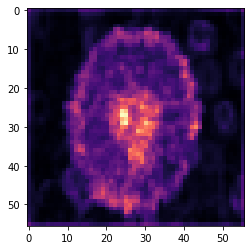

In [28]:
plt.imshow(avg_acts, cmap='magma');

In [29]:
def plot_forward_activations_multi(hooks):
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            ax[i,j].imshow(avg_acts, cmap='magma')
            ind+=1
            
    plt.show()

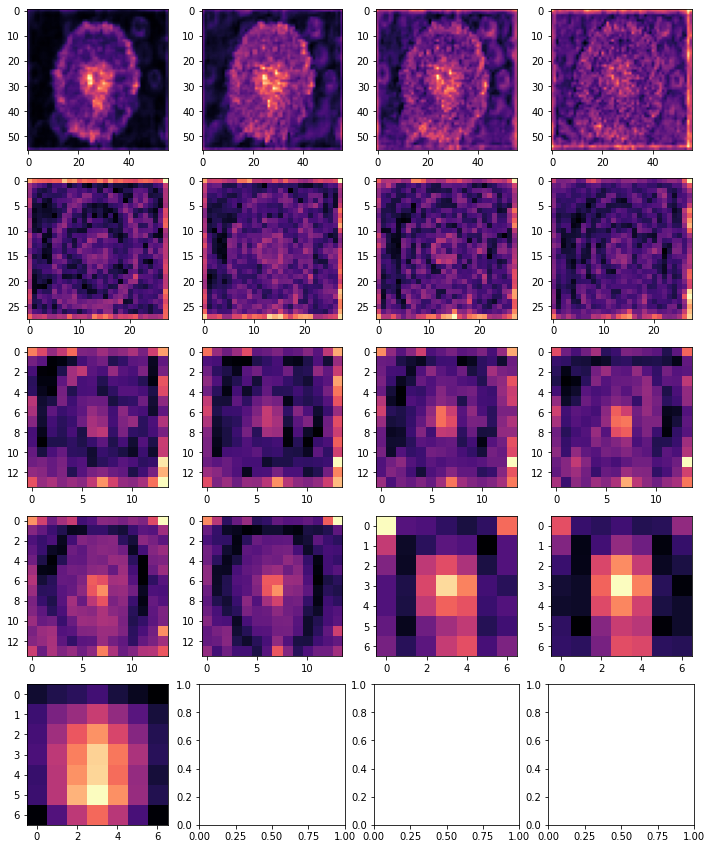

In [30]:
plot_forward_activations_multi(hooks)

In [31]:
def plot_non_class_discriminative_heatmaps_multi(x):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    hooks,_ = non_class_discriminative_activations_multi(xb)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts  = hooks[ind].stored[0].cpu()
            avg_acts = acts.mean(0)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(avg_acts, alpha=0.6, extent=(0,224,224,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

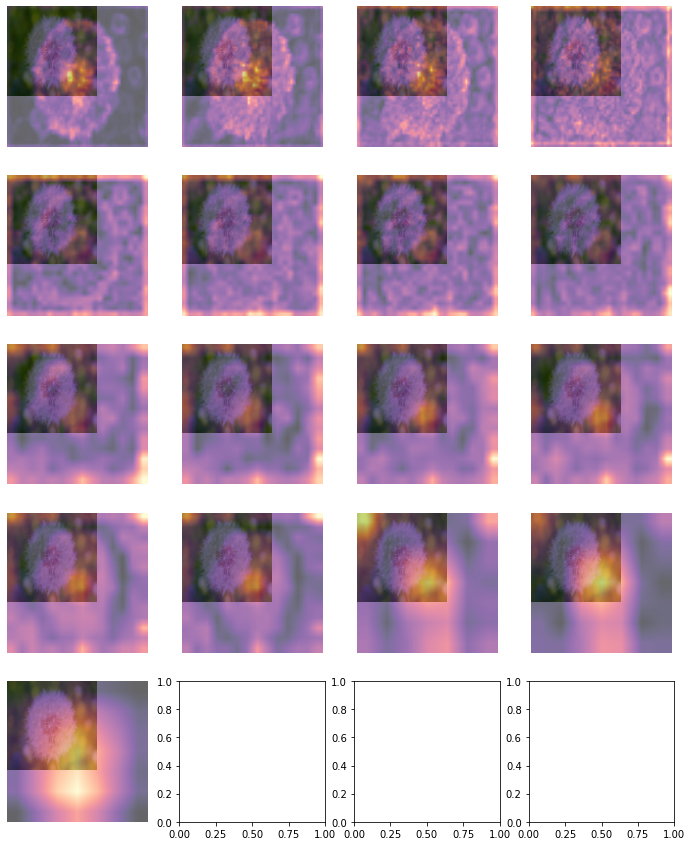

In [32]:
plot_non_class_discriminative_heatmaps_multi(x)

# ***Let's see how the Grad-CAM heat-maps look at different points in the network. Again, on more info on how Grad-CAM works, refer back to previous post.***

In [33]:
def class_discriminative_gradients_multi(xb, cat):
    hooks_a = []
    hooks_g = []
    layer_names = []
    
    hooks_a.append(hook_output(m[0][3]))
    hooks_g.append(hook_output(m[0][3], grad=True))
    
    layer_names.append('first conv')

    for ind in [4,5,6,7]:
        for i,el in enumerate(learn.model[0][ind]):
            hooks_a.append(hook_output(el))
            hooks_g.append(hook_output(el, grad=True))
            layer_names.append(f'layer-{ind-3} - conv-{i+1}')
            # layer 1 (layer is combination of resnet blocks) is model[0][4]
    
    preds = m(xb)
    preds[0,int(cat)].backward()
    
    for hook in hooks_a:
        hook.remove()
        
    for hook in hooks_g:
        hook.remove()
    
    return hooks_a,hooks_g,layer_names

In [36]:
def plot_class_discriminative_heatmaps_multi(x,cat=None,relu=True):
    
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    if cat is None:
        y_to_get_gradients_for = y.data
    else:
        y_to_get_gradients_for = cat
    
    hooks_a,hooks_g,_ = class_discriminative_gradients_multi(xb,y_to_get_gradients_for)
    
    num_cols = 4
    num_rows = ceil(len(hooks)/num_cols)

    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    ind = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            if ind>=len(hooks):
                break
            
            acts = hooks_a[ind].stored[0].cpu()
            grad = hooks_g[ind].stored[0][0].cpu()

            grad_chan = grad.mean(1).mean(1)
            mult = (acts*grad_chan[...,None,None]).mean(0)

            if relu:
                mult = F.relu(mult)

            xb_im.show(ax[i,j])
            ax[i,j].imshow(mult, alpha=0.6, extent=(0,224,224,0),
                      interpolation='bilinear', cmap='magma');
            ind+=1
            
    plt.show()

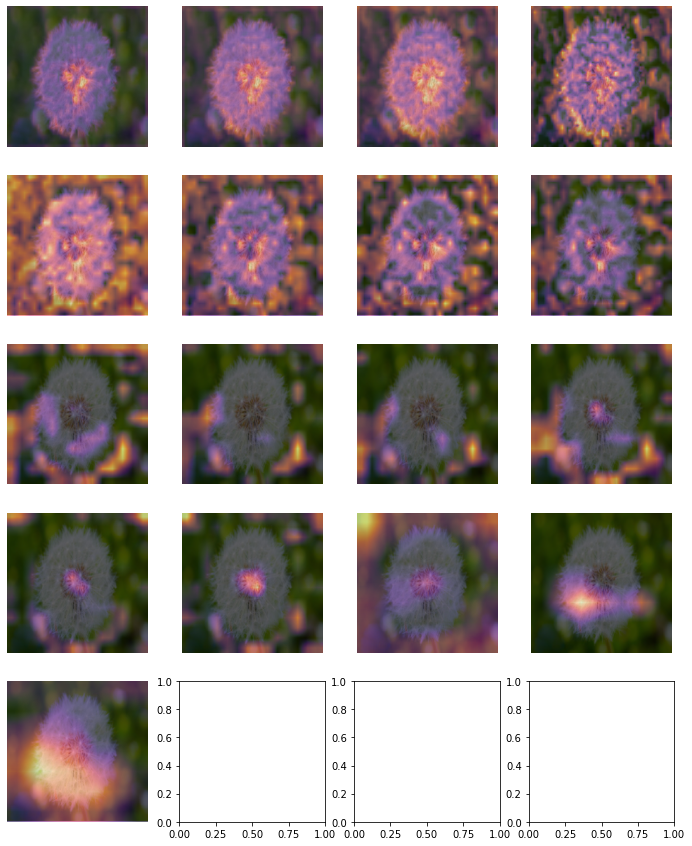

In [37]:
plot_class_discriminative_heatmaps_multi(x)